# Description data set

#### train.csv- Личные записи примерно двух третей (~8700) пассажиров, которые будут использоваться в качестве обучающих данных.

#### PassengerId- Уникальный идентификатор для каждого пассажира. Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, с которой путешествует пассажир, и pp является их номером в группе. Люди в группе часто являются членами семьи, но не всегда.

#### HomePlanet- Планета, с которой вылетел пассажир, как правило, планета его постоянного проживания.

#### CryoSleep- Указывает, решил ли пассажир быть переведен в режим анабиоза на время рейса. Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.

#### Cabin- Номер каюты, в которой находится пассажир. Принимает вид deck/num/side, где side может быть либо P левый , либо S правый борт .

#### Destination- Планета, на которую будет высаживаться пассажир.

#### Age- Возраст пассажира.

#### VIP- Оплатил ли пассажир специальное VIP-обслуживание во время рейса.

#### RoomService, FoodCourt, ShoppingMall, Spa, VRDeck- Сумма, которую пассажир выставил в счет за каждое из многочисленных роскошных удобств космического корабля Титаник .

#### Name- Имя и фамилия пассажира.

#### Transported- Был ли пассажир перенесён в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.

#### test.csv — личные записи оставшейся трети (~ 4300) пассажиров, которые будут использоваться в качестве тестовых данных. Ваша задача состоит в том, чтобы предсказать значение Transported для пассажиров в этом наборе.

#### sample_submission.csv — файл отправки в правильном формате.

#### PassengerId- Id для каждого пассажира в тестовом наборе.

#### Transported- Цель. Для каждого пассажира предскажите либо True или False.

In [82]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Задаем параметр рандомности для того чтобы результат можно было повторить
SEED = 42

In [83]:
# Тренировачный ДС
train = pd.read_csv(r"train.csv")

# Тестовый ДС
test = pd.read_csv(r"test.csv")

# Образец вывода результата
sample = pd.read_csv(r"sample_submission.csv")

In [84]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [85]:
#Смотрим размер ДС
train.shape

(8693, 14)

In [86]:
#Удаляем дубликаты объектов, в данном случае их нет
train = train.drop_duplicates()
train.shape

(8693, 14)

In [87]:
# Т.к. признак 'Cabin' по описанию имеет расположение кают: P-левый борт S-правый борт
#Так же этот признак несет в себе обозначение палуб
#Из признака 'Cabin', создадим два новых признака 'Deck' и 'Side'
#Преобразуем эти признаки в числовые для тренировочного и тестового ДС

def LabelEncoder(split):
    
    # Импортируем модуль для преобразования квтегориальных признаков в числовые
    from sklearn.preprocessing import LabelEncoder as le
    
    # Для начала разобьем на символы строки
    split_cabin = split['Cabin'].str.split('/', expand=True)
    
    # Преобразуем признаки
    for col in split_cabin:
        split_cabin[col] = le().fit_transform(split_cabin[col])
    return split_cabin

# Создадим два новых числовых признака из катекориального признака "Cabin"
train['Deck'], train['Side'] = LabelEncoder(train)[0], LabelEncoder(train)[2] 
test['Deck'], test['Side'] = LabelEncoder(test)[0], LabelEncoder(test)[2]

#  Для удобства поставин нецелевой признак в конец
train = train.reindex(columns= ['PassengerId', 'HomePlanet', 'CryoSleep', 
                                'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 
                                'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 
                                'Deck', 'Side', 'Transported'])

In [88]:
# Признак 'Name' не несет в себе важную составляющую, т.к. почти все объекты уникальные
unique_name = len(train['Name'].unique())
shape_df = len(train)
print(f'unique_name of all_name: ({unique_name}, {shape_df})')

# Поэтому 'Name' удаляем и 'Cabin' т.к. он тоже уже не нужен
train = train.drop(['Name', 'Cabin'], axis = 1)
test = test.drop(['Name', 'Cabin'], axis = 1)

unique_name of all_name: (8474, 8693)


In [89]:
# Преобразовываем категориальные признаки в числовые
from sklearn.preprocessing import LabelEncoder as le
cols_to_transform = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']
for col in cols_to_transform:
    train[col] = le().fit_transform(train[col])
    test[col] = le().fit_transform(test[col])

In [90]:
# Видим наличие пропусков в тренировочном и тестовом ДС
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   int32  
 2   CryoSleep     8693 non-null   int32  
 3   Destination   8693 non-null   int32  
 4   Age           8514 non-null   float64
 5   VIP           8693 non-null   int32  
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Deck          8693 non-null   int32  
 12  Side          8693 non-null   int32  
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), int32(6), object(1)
memory usage: 755.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Nu

(None, None)

In [91]:
# Заполним пропуски с помощью KNN
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Создадим функцию т.к. этот код нам пригодится не раз
def filling_in_gaps(data):
    # Выбираем все признаки кроме первого, т.к. это Id и он является категориальным признаком
    data_except_first = data.drop(['PassengerId'], axis=1)
    # Разделяем данные на две части
    data_with_nan = data_except_first # С пропусками
    data_without_nan = data_except_first.dropna() # Без пропусков
    
    # Находим среднее и стандарьное отклонение данных без пропущенных значений для нормальзации данных
    means = data_without_nan.mean()
    stds = data_without_nan.std()
    data_normalized = (data_without_nan - means) / stds
    
    # Применяем KNN для заполнения пропущенных значений
    imputer = KNNImputer(n_neighbors=20)
    data_with_nan_normalized = (data_with_nan - means) / stds
    data_filled = imputer.fit_transform(data_with_nan_normalized)

    # Создаем новый DataFrame с заполненными значениями
    data_filled_normalized = pd.DataFrame(data_filled, columns = data_except_first.columns.tolist())
    data_filled_denormalized = data_filled_normalized * stds + means
    data_result = pd.concat([data.iloc[:, 0], data_filled_denormalized], axis=1)
    data = data_result
    
    # Выводим результат
    return data

# Применяем функцию к тренировочному и тестовому ДС
train = filling_in_gaps(train)
test = filling_in_gaps(test)

In [92]:
# Пропусков больше нет
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   float64
 2   CryoSleep     8693 non-null   float64
 3   Destination   8693 non-null   float64
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   float64
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Deck          8693 non-null   float64
 12  Side          8693 non-null   float64
 13  Transported   8693 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1018.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  

(None, None)

In [93]:
#Смотрим статистические значения
#Есть подозрение, что признаки: 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', содержат выбросы
train.describe().T

,count,mean,std,min,25%,50%,75%,max
HomePlanet,8693.0,0.719199,0.863402,0.000000e+00,0.0,0.0,1.00,3.0
CryoSleep,8693.0,0.399287,0.538345,0.000000e+00,0.0,0.0,1.00,2.0
Destination,8693.0,1.515242,0.840148,0.000000e+00,1.0,2.0,2.00,3.0
Age,8693.0,28.803802,14.370343,0.000000e+00,19.0,27.0,37.00,79.0
VIP,8693.0,0.069596,0.333871,0.000000e+00,0.0,0.0,0.00,2.0
RoomService,8693.0,225.074433,661.870979,-2.842171e-14,0.0,0.0,58.00,14327.0
FoodCourt,8693.0,456.238324,1598.910063,0.000000e+00,0.0,0.0,84.15,29813.0
ShoppingMall,8693.0,173.284027,598.844584,0.000000e+00,0.0,0.0,31.00,23492.0
Spa,8693.0,310.300863,1127.048181,0.000000e+00,0.0,0.0,71.00,22408.0
VRDeck,8693.0,304.206988,1137.901585,0.000000e+00,0.0,0.0,54.00,24133.0


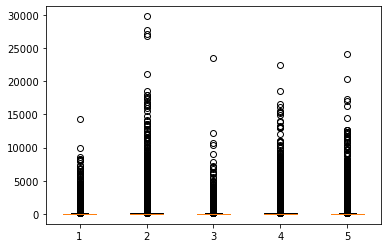

In [94]:
import matplotlib.pyplot as plt
import numpy as np

def box(df):
    emissions = df[['RoomService', 'FoodCourt', 'ShoppingMall', 
              'Spa', 'VRDeck']]
    #Создаем график boxplot
    fig, ax = plt.subplots()
    ax.boxplot(emissions)
    return plt.show() # Действительно видим множество выбросов
box(train)

In [95]:
# Очищаем данные от выбросов
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

# Эта функция содержит в себе цикл, в котором методом KNN очищаются данные от выбросов
# Перед началом нового цикла происходит заполнение пропуском по методу KNN
# Цикл останавливается, когда значение количества выбросов начинают повторяться
def del_of_outliers(data):
    my_list = []
    while True:
        # Отбор признаков
        signs = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        data_outliers = data[signs]

        # Масштабирование данных
        scaled_outliers = (data_outliers - data_outliers.mean()) / data_outliers.std()

        # Обнаружение выбросов с помощью KNN
        clf = LocalOutlierFactor(n_neighbors=20)
        outliers_cls = clf.fit_predict(scaled_outliers)
    
        # Удаление выбросов
        df_clean = data[outliers_cls == 1]
        data[signs] = df_clean[signs]
    
        data = filling_in_gaps(data)
        
        new_value = (len(df_clean == 1))
        
        if new_value in my_list:  # если значение уже есть в списке то цикл остановится
            print("Это значение уже есть в списке. Цикл остановлен.")
            break
        my_list.append(new_value) 
        print(my_list)
    return data

train = del_of_outliers(train)
test = del_of_outliers(test)

[7914]
[7914, 8421]
[7914, 8421, 8541]
[7914, 8421, 8541, 8576]
[7914, 8421, 8541, 8576, 8588]
[7914, 8421, 8541, 8576, 8588, 8614]
[7914, 8421, 8541, 8576, 8588, 8614, 8620]
[7914, 8421, 8541, 8576, 8588, 8614, 8620, 8628]
[7914, 8421, 8541, 8576, 8588, 8614, 8620, 8628, 8643]
[7914, 8421, 8541, 8576, 8588, 8614, 8620, 8628, 8643, 8645]
[7914, 8421, 8541, 8576, 8588, 8614, 8620, 8628, 8643, 8645, 8648]
[7914, 8421, 8541, 8576, 8588, 8614, 8620, 8628, 8643, 8645, 8648, 8647]
Это значение уже есть в списке. Цикл остановлен.
[3800]
[3800, 4114]
[3800, 4114, 4179]
[3800, 4114, 4179, 4212]
[3800, 4114, 4179, 4212, 4225]
[3800, 4114, 4179, 4212, 4225, 4232]
[3800, 4114, 4179, 4212, 4225, 4232, 4236]
[3800, 4114, 4179, 4212, 4225, 4232, 4236, 4238]
[3800, 4114, 4179, 4212, 4225, 4232, 4236, 4238, 4239]
[3800, 4114, 4179, 4212, 4225, 4232, 4236, 4238, 4239, 4240]
Это значение уже есть в списке. Цикл остановлен.


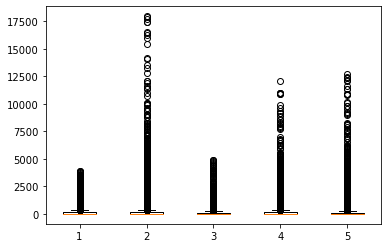

In [96]:
# Выбросов стало значительно меньше
box(train)

In [97]:
#Передаем переменной 'X' не целевые признаки
X = train.drop(['Transported'], axis = 1)
#Передаем переменной 'y' целевой признак
y = train['Transported']

In [98]:
# Разделяем данные на тренировочные и тестовые
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Стандартизируем только X_train
scaler = StandardScaler()
scaler.fit(X_train)

# Масштабируем оба X_train и X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

(X_train.shape, X_test.shape)

((6085, 13), (2608, 13))

In [99]:
# Смотрим результат стандартизации
col_names=['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP','RoomService', 'FoodCourt', 'ShoppingMall', 
              'Spa', 'VRDeck', 'deck', 'side', 'Transported']
scaled_df = pd.DataFrame(X_train, columns=col_names)
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
HomePlanet,6085.0,1.429332e-16,1.000082,-1.750793,-0.855250,-0.006502,0.841490,1.750623
CryoSleep,6085.0,3.877114e-17,1.000082,-0.829050,-0.829050,-0.829050,0.332804,2.656510
Destination,6085.0,-5.586693e-17,1.000082,-0.729944,-0.729944,-0.729944,1.130068,2.990079
Age,6085.0,5.263023e-16,1.000082,-1.798107,-0.608040,0.582028,0.582028,1.772096
VIP,6085.0,-4.267790e-17,1.000082,-2.005193,-0.614376,-0.127590,0.567818,3.488534
RoomService,6085.0,-5.478590e-16,1.000082,-0.212828,-0.212828,-0.212828,-0.212828,5.607667
FoodCourt,6085.0,-5.556315e-16,1.000082,-0.439050,-0.439050,-0.439050,-0.074302,8.463088
ShoppingMall,6085.0,-2.352747e-16,1.000082,-0.317516,-0.317516,-0.317516,-0.208693,13.343802
Spa,6085.0,-9.104376e-17,1.000082,-0.373617,-0.373617,-0.373617,-0.117380,12.367278
VRDeck,6085.0,3.226854e-16,1.000082,-0.338617,-0.338617,-0.338617,-0.152220,13.179938


In [67]:
# Применим метод "Decision Tree"

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Импортируем метрики
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# В результате получем качесто предсказания 78%
# В среднем дерево правильно классифицировало 77%-False и 78%-True 

[[ 981  308]
 [ 270 1049]]
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77      1289
         1.0       0.77      0.80      0.78      1319

    accuracy                           0.78      2608
   macro avg       0.78      0.78      0.78      2608
weighted avg       0.78      0.78      0.78      2608



In [68]:
# Применим метод "SVM"

from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# В результате получем качесто предсказания 81%
# В среднем метод правильно классифицировал 78%-False и 83%-True 

[[ 891  398]
 [ 110 1209]]
              precision    recall  f1-score   support

         0.0       0.89      0.69      0.78      1289
         1.0       0.75      0.92      0.83      1319

    accuracy                           0.81      2608
   macro avg       0.82      0.80      0.80      2608
weighted avg       0.82      0.81      0.80      2608



In [69]:
# Применим метод "Logistic Regression"

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, random_state=SEED)
clf.fit(X_train, y_train)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# В результате получем качесто предсказания 79%
# В среднем метод правильно классифицировал 77%-False и 81%-True 

[[ 891  398]
 [ 110 1209]]
              precision    recall  f1-score   support

         0.0       0.89      0.69      0.78      1289
         1.0       0.75      0.92      0.83      1319

    accuracy                           0.81      2608
   macro avg       0.82      0.80      0.80      2608
weighted avg       0.82      0.81      0.80      2608



In [70]:
# Применим метод "Naive Bayes"

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# В результате получем качесто предсказания 77%
# В среднем метод правильно классифицировал 71%-False и 80%-True 

[[ 759  530]
 [  76 1243]]
              precision    recall  f1-score   support

         0.0       0.91      0.59      0.71      1289
         1.0       0.70      0.94      0.80      1319

    accuracy                           0.77      2608
   macro avg       0.81      0.77      0.76      2608
weighted avg       0.80      0.77      0.76      2608



In [71]:
# Для улечшения качества предсказания используем ансамбль "Staking"

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB


# создание экземпляров моделей
model1 = DecisionTreeClassifier(random_state=SEED)
model2 = LogisticRegression(random_state=SEED)
model3 = SVC(kernel='linear', random_state=SEED)
model4 = GaussianNB()

# создание ансамбля моделей с помощью VotingClassifier
ensemble_model = VotingClassifier(estimators=[('dt', model1), ('lr', model2), ('svc', model3), ('nb', model4)], voting='hard')

# обучение ансамбля на обучающем наборе
ensemble_model.fit(X_train, y_train)

# оценка производительности ансамбля на тестовом наборе
accuracy = ensemble_model.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 80.41%


In [72]:
# Ансамбль "Bagging"

from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Создание базовой модели
base_model = SVC(random_state=SEED)

# Создание бэггинг-модели на основе базовой модели
bagging_model = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=SEED)

# Обучение бэггинг-модели на обучающем наборе данных
bagging_model.fit(X_train, y_train)

# Оценка точности модели на тестовом наборе данных
y_pred = bagging_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 80.98%


In [73]:
# Ансамбль "Boosting"

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Создание классификатора
dtc = DecisionTreeClassifier(max_depth=1)

# Создание модели бустинга
model = AdaBoostClassifier(base_estimator=dtc, n_estimators=500, learning_rate=0.1)

# Обучение модели на обучающей выборке
model.fit(X_train, y_train)

# Получение прогнозов для тестовой выборки
y_pred = model.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 80.56%


In [74]:
# Ансамбль "XGBoost"

import xgboost as xgb
from sklearn.metrics import accuracy_score
# инициализация классификатора XGBoost
clf = xgb.XGBClassifier()

# обучение модели
clf.fit(X_train, y_train)

# предсказание классов для тестовой выборки
y_pred = clf.predict(X_test)

# вычисление точности классификации
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 82.02%


In [100]:
# Используем метод поиска наилучших гиперпараметров "RandomizedSearch"

from sklearn.model_selection import RandomizedSearchCV

# Определение диапазона значений параметра, которые необходимо проверить
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5, 10, 15, 20, 25, 30, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Создание модели
rfc = RandomForestClassifier()

# Создание объекта RandomizedSearch с использованием 5-кратной кросс-валидации
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Обучение модели с использованием RandomizedSearch
random_search.fit(X_train, y_train)

# Вывод наилучшего значения параметра k и соответствующего значения точности
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
0.8348397699260476


In [102]:
# Используя параметры выше, применим ансамбль "Random Forest"
from sklearn.ensemble import RandomForestClassifier


# Создание и обучение случайного леса из 100 решающих деревьев
rfc = RandomForestClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf=2, 
                             max_features='sqrt', max_depth=None,  random_state=SEED)
rfc.fit(X_train, y_train)

# Оценка точности на тестовом наборе данных
accuracy = rfc.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 82.71%


In [103]:
# Наилучшее качествопоказал ансамбль "Random Forest"
# Передаем обученой модели данные, который необходимо предсказать и приведем к требуемому формату
test_scaler = scaler.transform(test)
test['Transported'] = rfc.predict(test_scaler).astype(bool)
test_predict = test[['PassengerId', 'Transported']]
test_predict

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [104]:
# Проверим соответствие даных примеру итогового предсказания

sample.info(), test_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


(None, None)

In [105]:
# Сохраним итоговое предсказание

test_predict.to_csv (r"test_predict.csv", index = False)